In [1]:
%pip install matplotlib
%pip install numpy==1.23.5
%pip install opencv-python
%pip install medpy==0.4.0
%pip install tqdm
%matplotlib inline
%pip install pandas
%pip install scikit-learn
%pip install chardet
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import sys
import os
plt.rcParams["figure.figsize"] = (15,15)

print(f"numpy version : {np.__version__}")
%load_ext autoreload
%autoreload 2

numpy version : 1.23.5


In [37]:
tf.test.is_gpu_available()

True

In [3]:
# from keras_unet.losses import dice_loss
# from keras_unet.metrics import dice_coef, iou, iou_thresholded
from keras_unet.visualization import plot_overlay_segmentation
from keras_unet.visualization import plot_compare_segmentation
from keras_unet.visualization import visualize_BestWorstOnes

# Add our own python modules stored in the folders present at the root level of this project
if "../" in sys.path: 
    print(sys.path)
else: 
    sys.path.append("../")
    print(sys.path)

if "model" in locals(): 
    print("deleting model")
    del model    
    
# Select the CPU device to run on
num_CPU = 1
num_cores = 8
tf.config.threading.set_intra_op_parallelism_threads(num_CPU)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3" 

['c:\\Users\\user\\Desktop\\zhuyi\\PTI\\camus-hands-on-main', 'c:\\Users\\user\\anaconda3\\envs\\py310\\python310.zip', 'c:\\Users\\user\\anaconda3\\envs\\py310\\DLLs', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib', 'c:\\Users\\user\\anaconda3\\envs\\py310', '', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages\\win32', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages\\win32\\lib', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages\\Pythonwin', '../']


***

# <span style="color:brown"> **1) Load and prepare dataset**
    
As for the previous part of the hands-on, you will use a the CAMUS dataset restricted to apical four-chamber views at End-Diastole and End-Systole time instants from 500 patients. This dataset was divided into three folds:

- ***dataset/segmentation/train*** representing 80% of the dataset. This subset will be used to train the network by updating its parameters to get the best results on the corresponding data.
- ***dataset/segmentation/valid*** representating 10% of the dataset. This subset will be used to select the network parameters which produce the best results on the training dataset.
- ***dataset/segmentation/test*** representing 10% of the dataset. This subset will be used to assess the scores that can reach the trained network on unseen data.    

## <span style="color:brown"> 1.1) Load data

In [4]:
from keras_unet.utils import load_CAMUS_dataset

# Parameters
IMG_SIZE = 256  # All the images will be resized to IMG_SIZE x IMG_SIZE to speed up the process. 

dataset_train_path = "dataset/segmentation/train/"
dataset_valid_path = "dataset/segmentation/valid/"
dataset_test_path = "dataset/segmentation/test/"

# Load data
[X_train_C, y_train_C] = load_CAMUS_dataset(dataset_train_path, IMG_SIZE)
[X_valid_C, y_valid_C] = load_CAMUS_dataset(dataset_valid_path, IMG_SIZE)
[X_test_C, y_test_C] = load_CAMUS_dataset(dataset_test_path, IMG_SIZE)

# Deleting the last dimension's index=1
y_train_C = np.delete(y_train_C, 1, axis=3)
print(y_train_C.shape)

y_valid_C = np.delete(y_valid_C, 1, axis=3)
print(y_valid_C.shape)

y_test_C = np.delete(y_test_C, 1, axis=3)
print(y_test_C.shape)


100%|██████████| 100/100 [00:00<00:00, 1919.59it/s]


(800, 256, 256, 3)
(100, 256, 256, 3)
(100, 256, 256, 3)


In [5]:
from keras_unet.utils import load_SUMAC_dataset
dataset_dir = "./dataset/sumac_256/"
X_S, y_S = load_SUMAC_dataset(dataset_dir, img_size=256, 
                          extension="nii.gz",random_state=42)
X_S.shape, y_S.shape

100%|██████████| 1000/1000 [00:02<00:00, 343.70it/s]


((1000, 256, 256, 1), (1000, 256, 256, 3))

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

# 假设 X_S 和 y_S 是原始的特征集和标签集
# 首先创建一个包含400个样本的初始训练集
X_train_S800, X_temp, y_train_S800, y_temp = train_test_split(X_S, y_S, test_size=0.2, random_state=42)
X_test_S, X_valid_S, y_test_S, y_valid_S = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 定义不同大小的训练集，包括400
# sizes = [800, 700, 600, 500, 400, 300, 200, 100, 1]
sizes = [70, 50, 30, 20, 10]


# 初始化用于存储不同训练集的字典
train_sets = {}

# 当前的训练集和剩余数据集
current_X_train = X_train_S800
current_y_train = y_train_S800

# 逐步分割出不同大小的训练集
for size in sizes:
    # 如果当前训练集大于目标大小，则从中分割出更小的训练集
    if len(current_X_train) > size:
        # 计算新训练集与当前训练集的大小差异
        difference = len(current_X_train) - size

        # 从当前训练集中分割出所需数量的样本
        X_smaller, X_temp, y_smaller, y_temp = train_test_split(current_X_train, current_y_train, test_size=difference/len(current_X_train), random_state=42)
        current_X_train, current_y_train = X_smaller, y_smaller

    # 存储当前大小的训练集
    train_sets[f"X_train_S{size}"] = current_X_train
    train_sets[f"y_train_S{size}"] = current_y_train

# 现在 train_sets 字典中包含了所有不同大小的训练集



In [7]:
train_sets["X_train_S70"].shape

(70, 256, 256, 1)

In [10]:
new_train_sets = {}

for size in sizes:
    # 从 train_sets 获取不同大小的 S 训练集
    X_train_S = train_sets[f"X_train_S{size}"]
    y_train_S = train_sets[f"y_train_S{size}"]

    # 合并 C 和 S 训练集
    X_train_combined = np.concatenate([X_train_C, X_train_S], axis=0)
    y_train_combined = np.concatenate([y_train_C, y_train_S], axis=0)

    # 打乱合并后的数据集
    X_train_shuffled, y_train_shuffled = shuffle(X_train_combined, y_train_combined, random_state=42)

    # 存储新的训练集
    new_train_sets[f"X_train{size}"] = X_train_shuffled
    new_train_sets[f"y_train{size}"] = y_train_shuffled

# 至此，new_train_sets 包含了所有合并并打乱后的新训练集



In [9]:
from sklearn.utils import shuffle

X_valid = np.concatenate([X_valid_C, X_valid_S], axis=0)
y_valid = np.concatenate([y_valid_C, y_valid_S], axis=0)

X_valid, y_valid = shuffle(X_valid, y_valid, random_state=42)

In [11]:
# Display the matrix size and pixel type for the return variables 
print(" Dimensions of X_train : ", new_train_sets["X_train70"].shape)
print(" Dimensions of y_train : ", new_train_sets["y_train50"].shape)
print(" ")
print(" Dimensions of X_valid : ", X_valid.shape)
print(" Dimensions of y_valid : ", y_valid.shape)
print(" ")
print(" Dimensions of X_test : ", X_test_C.shape)
print(" Dimensions of y_test : ", y_test_C.shape)
print(" ")
print(" Dimensions of X_test : ", X_test_S.shape)
print(" Dimensions of y_test : ", y_test_S.shape)

 Dimensions of X_train :  (870, 256, 256, 1)
 Dimensions of y_train :  (850, 256, 256, 3)
 
 Dimensions of X_valid :  (200, 256, 256, 1)
 Dimensions of y_valid :  (200, 256, 256, 3)
 
 Dimensions of X_test :  (100, 256, 256, 1)
 Dimensions of y_test :  (100, 256, 256, 3)
 
 Dimensions of X_test :  (100, 256, 256, 1)
 Dimensions of y_test :  (100, 256, 256, 3)


***

# <span style="color:brown"> **2) Prepare the U-Net architecture**
    
## <span style="color:brown"> 2.1) Define important parameters
    
### <span style="color:red"> Instruction: </span> Run the cell below to select the values of the main parameters that define a U-Net architecture.

In [13]:
# Network architecture related values 
NBFILTERS_L1_UNET = 32  # Number of feature maps for the first level
NBLAYERS_UNET = 4       # Number of levels
DROPOUT_RATE = 0.1      # Dropout action used at each level (value between 0.0 and 1.0, 0.0 meaning no dropout)
BATCHNORM_ON = True     # Use of batch normalisation after each convolutional layer (value = True or False)

# Training parameters
NBEPOCHS = 500         # Number of epochs
BATCH_SIZE = 16         # Number of samples in each batch (usually the value is a multiple of 2)
NBSTEPS_PER_EPOCH = 50  # Number of batches per epoch (1  to ...) (used for data augmentation)
NBPATIENCE_EPOCHS = 50  # Number of epoch after a minimum detection before stopping (early stop)

## <span style="color:brown"> 2.2) Prepare a generator for data augmentation
    
During the learning phase of a deep learning model, it is generally recommended to use a data augmentation strategy to improve the generalization capability of the algorithm. Data augmentation consists of applying some pre-defined transformation operations (*e.g.* rotation, translation or pixel intensity clipping, etc...) on the input data during the filling of the batches. By doing so, the algorithm will never see the exact same input images, which will force it to be less sensitive to the changes applied.

In [14]:
from keras_unet.utils import get_augmented

# 定义数据增强参数
data_gen_args = dict(
    rotation_range=5.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='constant',
    cval=0
)

# 初始化一个字典来存储所有的数据增强生成器
train_generators = {}

# 对于 new_train_sets 中的每个训练集创建一个数据增强生成器
for size in sizes:
    X_train = new_train_sets[f"X_train{size}"]
    y_train = new_train_sets[f"y_train{size}"]

    # 创建数据增强生成器
    train_gen = get_augmented(
        X_train, y_train, batch_size=BATCH_SIZE,  
        data_gen_args=data_gen_args
    )

    # 将生成器存储在字典中
    train_generators[f"train_gen{size}"] = train_gen

# 至此，train_generators 字典包含了所有不同训练集大小的数据增强生成器


In [15]:
from keras_unet.losses import dice_loss
from keras_unet.metrics import dice_coef
from tensorflow.keras.optimizers import Adam
from keras_unet.visualization import plot_segm_history
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import datetime
from keras_unet.models import custom_unet
from tensorflow.keras import models
from tensorflow.keras import regularizers

 -> model_study :  trained_Unet_size70_f32_b16_l4_do0.1_Std_BN
 -> model_filename :  trained_model/CS/trained_Unet_size70_f32_b16_l4_do0.1_Std_BN_input_epoch_{epoch:02d}.h5
Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 0.4347 - dice_coef: 0.3803
Epoch 1: val_dice_coef improved from -inf to 0.26153, saving model to trained_model/CS\trained_Unet_size70_f32_b16_l4_do0.1_Std_BN_input_epoch_01.h5
50/50 [==============================] - 36s 340ms/step - loss: 0.4347 - dice_coef: 0.3803 - val_loss: 0.7016 - val_dice_coef: 0.2615
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.3806 - dice_coef: 0.4229
Epoch 2: val_dice_coef did not improve from 0.26153
50/50 [==============================] - 16s 315ms/step - loss: 0.3806 - dice_coef: 0.4229 - val_loss: 0.5967 - val_dice_coef: 0.2388
Epoch 3/500
50/50 [==============================] - ETA: 0s - loss: 0.3812 - dice_coef: 0.4265
Epoch 3: val_dice_coef did not improve from 0.26153
50/50 [===========

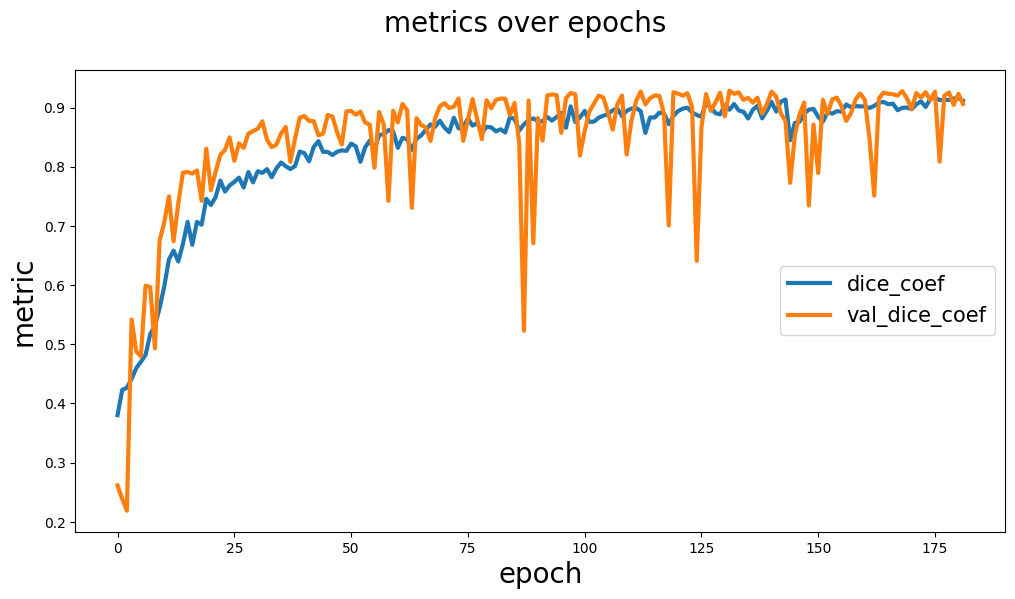

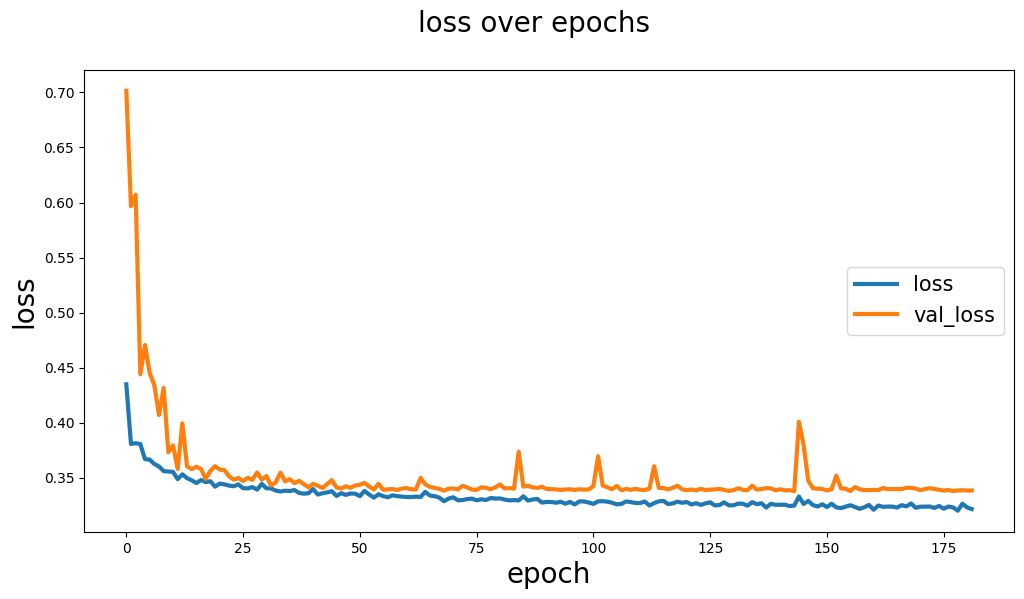

 -> model_study :  trained_Unet_size50_f32_b16_l4_do0.1_Std_BN
 -> model_filename :  trained_model/CS/trained_Unet_size50_f32_b16_l4_do0.1_Std_BN_input_epoch_{epoch:02d}.h5
Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 0.4498 - dice_coef: 0.3699
Epoch 1: val_dice_coef improved from -inf to 0.14053, saving model to trained_model/CS\trained_Unet_size50_f32_b16_l4_do0.1_Std_BN_input_epoch_01.h5
50/50 [==============================] - 16s 278ms/step - loss: 0.4498 - dice_coef: 0.3699 - val_loss: 0.7005 - val_dice_coef: 0.1405
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.3846 - dice_coef: 0.4176
Epoch 2: val_dice_coef improved from 0.14053 to 0.18309, saving model to trained_model/CS\trained_Unet_size50_f32_b16_l4_do0.1_Std_BN_input_epoch_02.h5
50/50 [==============================] - 14s 287ms/step - loss: 0.3846 - dice_coef: 0.4176 - val_loss: 0.6401 - val_dice_coef: 0.1831
Epoch 3/500
50/50 [==============================] - ETA: 0s - los

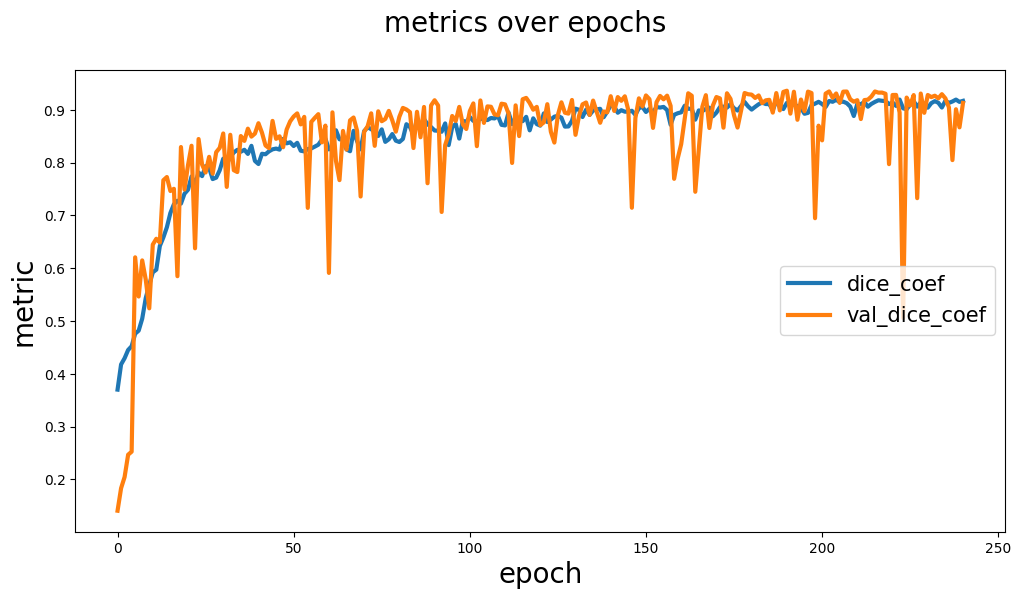

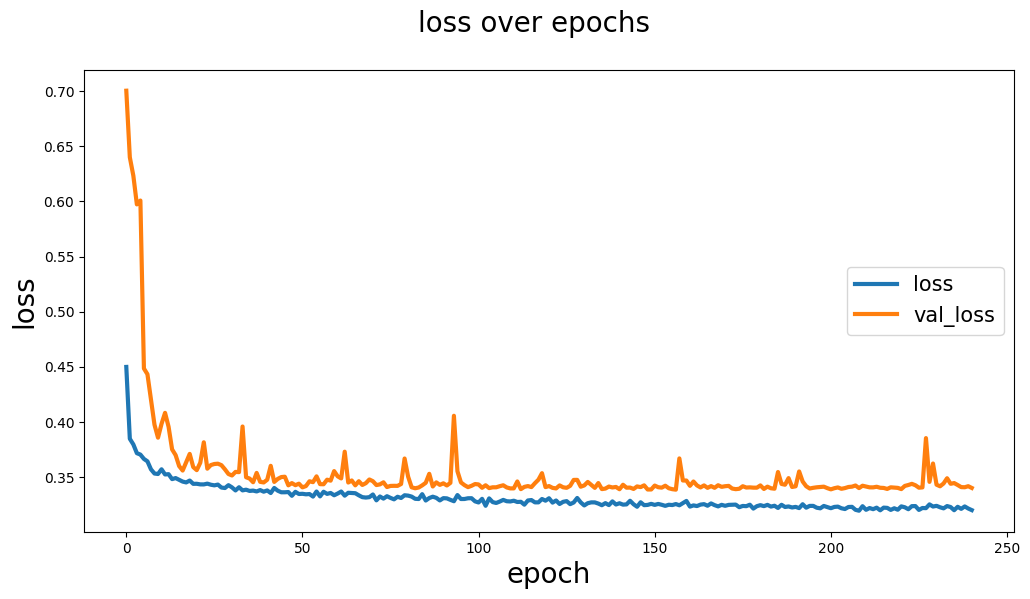

 -> model_study :  trained_Unet_size30_f32_b16_l4_do0.1_Std_BN
 -> model_filename :  trained_model/CS/trained_Unet_size30_f32_b16_l4_do0.1_Std_BN_input_epoch_{epoch:02d}.h5
Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 0.4374 - dice_coef: 0.3756
Epoch 1: val_dice_coef improved from -inf to 0.27388, saving model to trained_model/CS\trained_Unet_size30_f32_b16_l4_do0.1_Std_BN_input_epoch_01.h5
50/50 [==============================] - 16s 281ms/step - loss: 0.4374 - dice_coef: 0.3756 - val_loss: 0.7018 - val_dice_coef: 0.2739
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.3738 - dice_coef: 0.4284
Epoch 2: val_dice_coef did not improve from 0.27388
50/50 [==============================] - 19s 389ms/step - loss: 0.3738 - dice_coef: 0.4284 - val_loss: 0.6685 - val_dice_coef: 0.1435
Epoch 3/500
50/50 [==============================] - ETA: 0s - loss: 0.3668 - dice_coef: 0.4413
Epoch 3: val_dice_coef did not improve from 0.27388
50/50 [===========

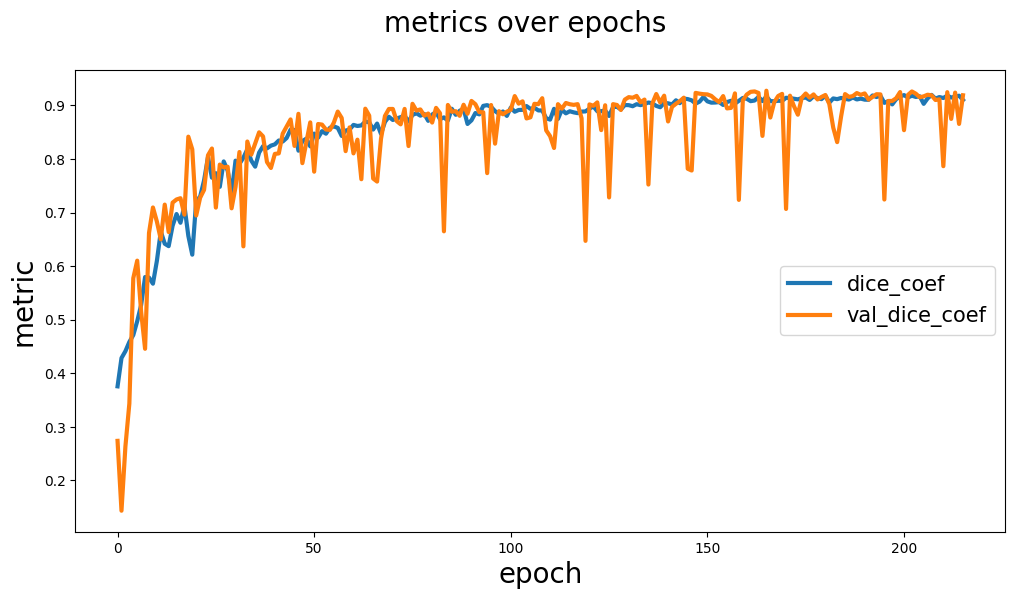

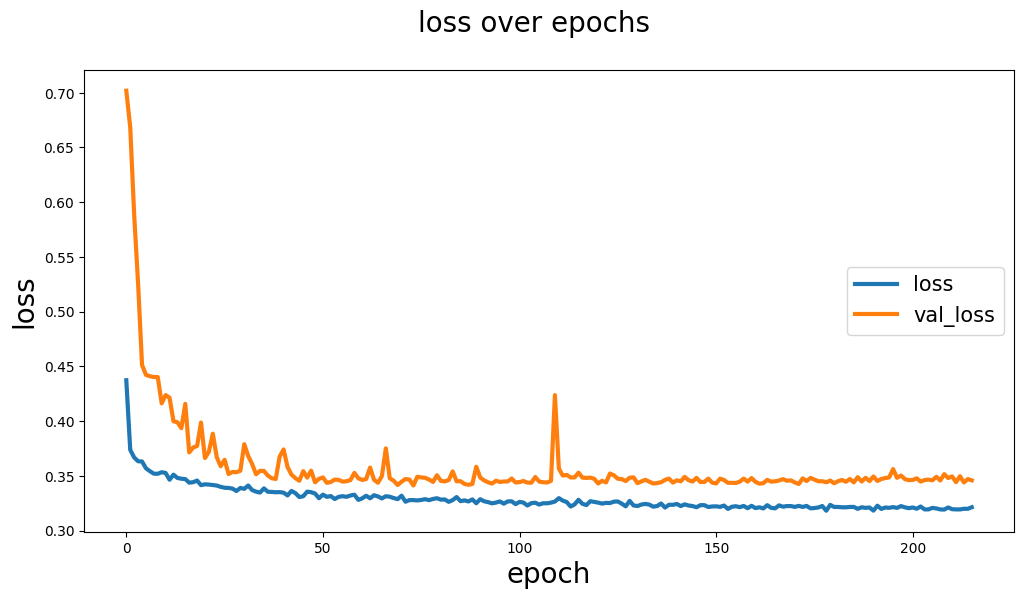

 -> model_study :  trained_Unet_size20_f32_b16_l4_do0.1_Std_BN
 -> model_filename :  trained_model/CS/trained_Unet_size20_f32_b16_l4_do0.1_Std_BN_input_epoch_{epoch:02d}.h5
Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 0.4461 - dice_coef: 0.3736
Epoch 1: val_dice_coef improved from -inf to 0.16683, saving model to trained_model/CS\trained_Unet_size20_f32_b16_l4_do0.1_Std_BN_input_epoch_01.h5
50/50 [==============================] - 16s 281ms/step - loss: 0.4461 - dice_coef: 0.3736 - val_loss: 0.6963 - val_dice_coef: 0.1668
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.3714 - dice_coef: 0.4289
Epoch 2: val_dice_coef improved from 0.16683 to 0.20843, saving model to trained_model/CS\trained_Unet_size20_f32_b16_l4_do0.1_Std_BN_input_epoch_02.h5
50/50 [==============================] - 16s 315ms/step - loss: 0.3714 - dice_coef: 0.4289 - val_loss: 0.6277 - val_dice_coef: 0.2084
Epoch 3/500
50/50 [==============================] - ETA: 0s - los

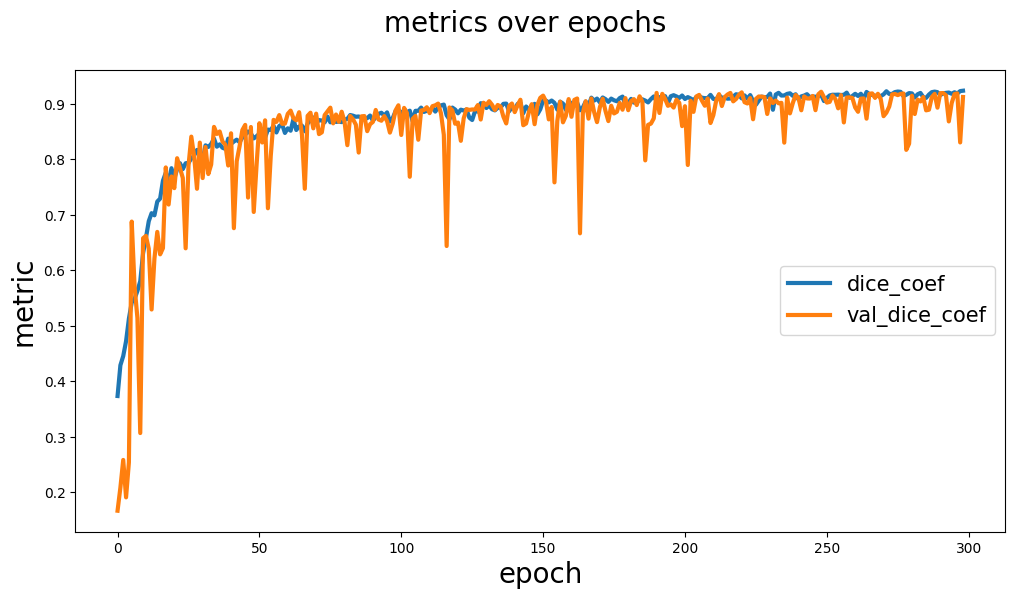

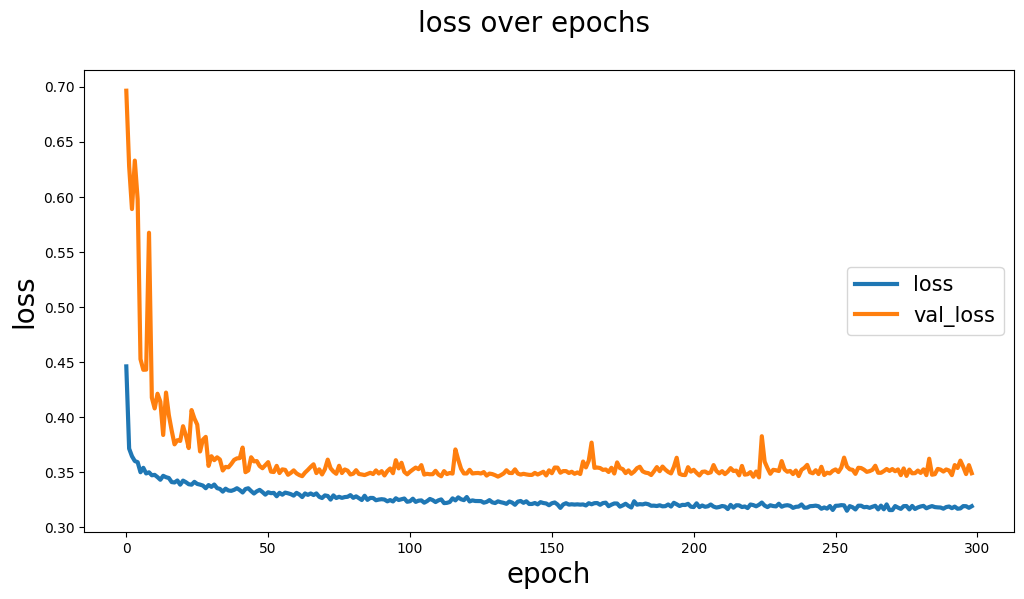

 -> model_study :  trained_Unet_size10_f32_b16_l4_do0.1_Std_BN
 -> model_filename :  trained_model/CS/trained_Unet_size10_f32_b16_l4_do0.1_Std_BN_input_epoch_{epoch:02d}.h5
Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 0.4417 - dice_coef: 0.3736
Epoch 1: val_dice_coef improved from -inf to 0.22986, saving model to trained_model/CS\trained_Unet_size10_f32_b16_l4_do0.1_Std_BN_input_epoch_01.h5
50/50 [==============================] - 16s 280ms/step - loss: 0.4417 - dice_coef: 0.3736 - val_loss: 0.6885 - val_dice_coef: 0.2299
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.3736 - dice_coef: 0.4286
Epoch 2: val_dice_coef did not improve from 0.22986
50/50 [==============================] - 18s 265ms/step - loss: 0.3736 - dice_coef: 0.4286 - val_loss: 0.6286 - val_dice_coef: 0.2227
Epoch 3/500
50/50 [==============================] - ETA: 0s - loss: 0.3632 - dice_coef: 0.4575
Epoch 3: val_dice_coef improved from 0.22986 to 0.27887, saving model 

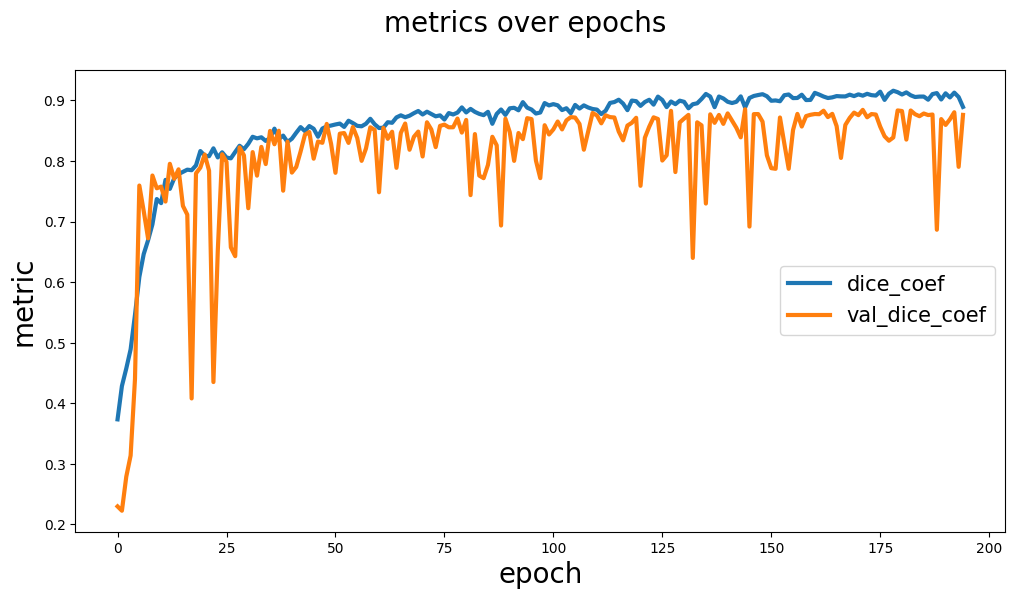

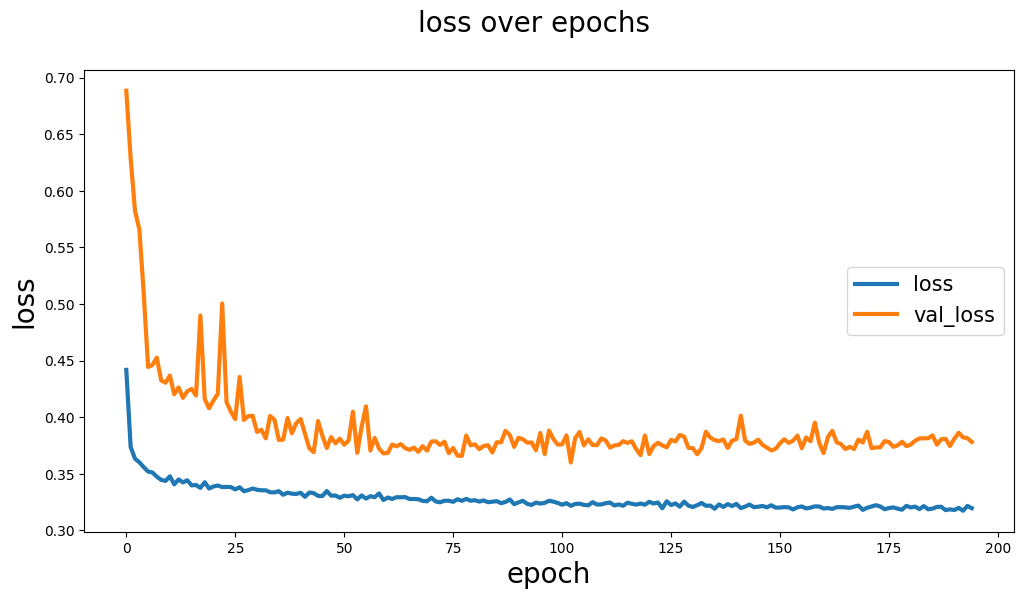

In [16]:
def train_model(train_gen, X_valid, y_valid, input_shape, size, model_path='trained_model/CS/'):
    # 定义模型
    if 'model' in locals(): 
        del model

    model = custom_unet(
        input_shape,
        use_batch_norm=BATCHNORM_ON,
        num_classes=y_train[0].shape[-1],
        filters=NBFILTERS_L1_UNET, 
        dropout=DROPOUT_RATE,
        num_layers=NBLAYERS_UNET,
        output_activation='softmax',
        kernel_regularizer=None
    )

    # 创建模型名称，包含训练集大小
    model_name = f'trained_Unet_size{size}_f{NBFILTERS_L1_UNET}_b{BATCH_SIZE}_l{NBLAYERS_UNET}_do{DROPOUT_RATE}_Std'
    if BATCHNORM_ON:
        model_name += '_BN'
    model_filename = os.path.join(model_path, f'{model_name}_input_epoch_{{epoch:02d}}.h5')
    print(" -> model_study : ", model_name)
    print(" -> model_filename : ", model_filename)

    # 创建回调函数
    callback_checkpoint = ModelCheckpoint(model_filename, verbose=1, monitor='val_dice_coef', mode='max', save_best_only=True)
    callback_earlystopping = EarlyStopping(monitor='val_dice_coef', mode='max', patience=NBPATIENCE_EPOCHS, restore_best_weights=True)
    current_datetime = datetime.datetime.now()
    log_folder_name = os.path.join("logs", f"{current_datetime.strftime('%Y%m%d_%H%M%S-')}{model_name}")
    os.makedirs(log_folder_name, exist_ok=True)
    tensorboard_callback = TensorBoard(log_dir=log_folder_name)

    # 编译模型
    model.compile(loss=dice_loss, optimizer=Adam(learning_rate=0.005), metrics=[dice_coef])

    # 训练模型
    history = model.fit(
        train_gen,
        steps_per_epoch=NBSTEPS_PER_EPOCH,
        batch_size=BATCH_SIZE,
        epochs=NBEPOCHS,
        validation_data=(X_valid, y_valid),
        shuffle=True,
        verbose=1,
        callbacks=[callback_earlystopping, callback_checkpoint, tensorboard_callback]
    )

    # 绘制训练历史
    plot_segm_history(history, metrics=['dice_coef', 'val_dice_coef'])

# 对于每个训练集大小，调用 train_model 函数
for size in sizes:
    train_gen = train_generators[f"train_gen{size}"]
    train_model(train_gen, X_valid, y_valid, input_shape=(IMG_SIZE, IMG_SIZE, 1), size=size)

 -> model_study :  trained_Unet_size800_f32_b16_l4_do0.1_Std_BN
 -> model_filename :  trained_model/CS/trained_Unet_size800_f32_b16_l4_do0.1_Std_BN_input_epoch_{epoch:02d}.h5
Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 0.4801 - dice_coef: 0.3568
Epoch 1: val_dice_coef improved from -inf to 0.23263, saving model to trained_model/CS\trained_Unet_size800_f32_b16_l4_do0.1_Std_BN_input_epoch_01.h5
50/50 [==============================] - 34s 341ms/step - loss: 0.4801 - dice_coef: 0.3568 - val_loss: 0.7060 - val_dice_coef: 0.2326
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.4196 - dice_coef: 0.4021
Epoch 2: val_dice_coef did not improve from 0.23263
50/50 [==============================] - 13s 260ms/step - loss: 0.4196 - dice_coef: 0.4021 - val_loss: 0.6828 - val_dice_coef: 0.2109
Epoch 3/500
50/50 [==============================] - ETA: 0s - loss: 0.4042 - dice_coef: 0.4172
Epoch 3: val_dice_coef did not improve from 0.23263
50/50 [========

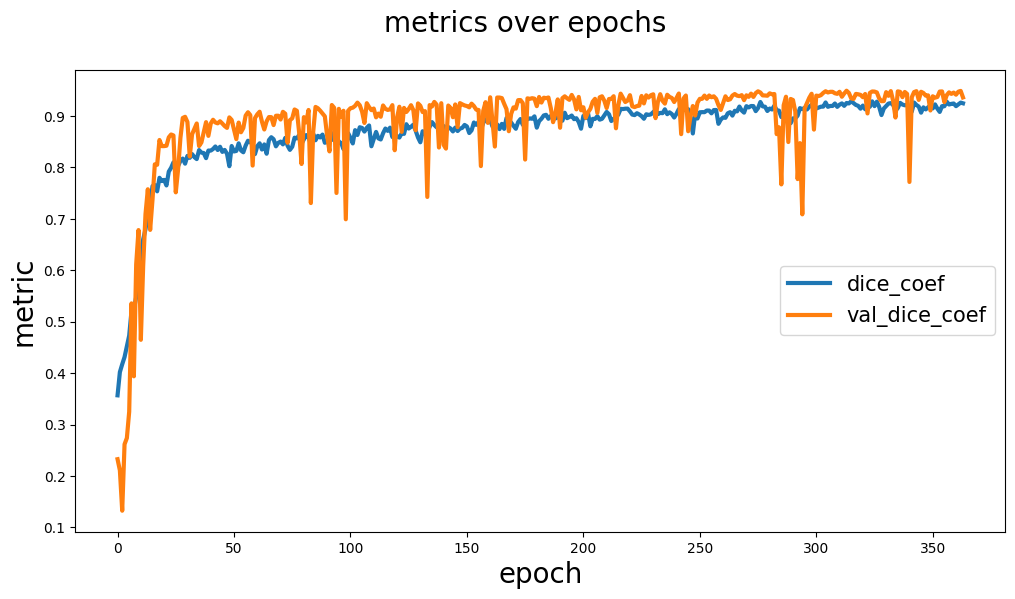

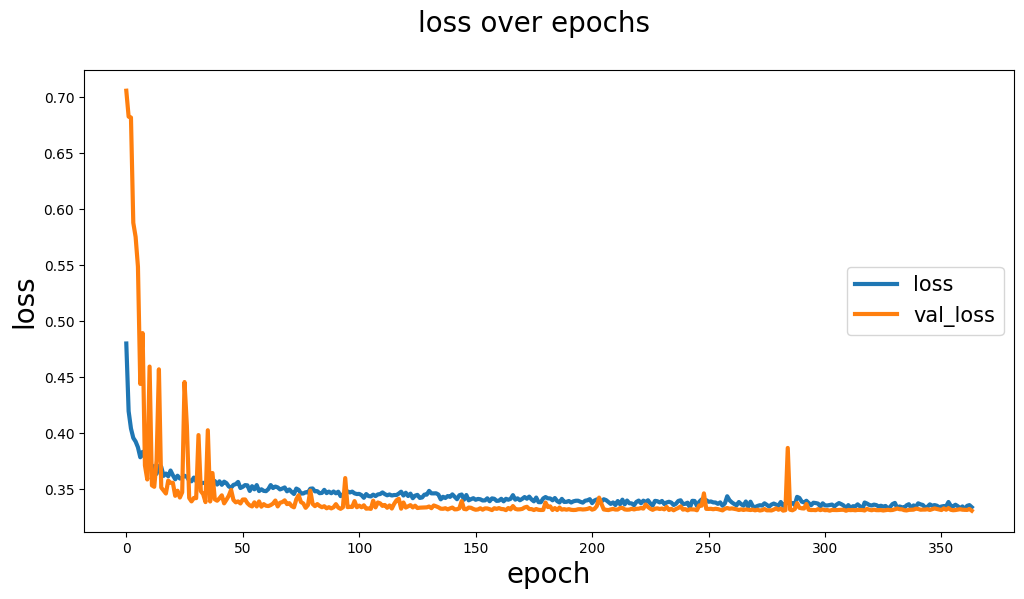

 -> model_study :  trained_Unet_size700_f32_b16_l4_do0.1_Std_BN
 -> model_filename :  trained_model/CS/trained_Unet_size700_f32_b16_l4_do0.1_Std_BN_input_epoch_{epoch:02d}.h5
Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 0.5017 - dice_coef: 0.3399
Epoch 1: val_dice_coef improved from -inf to 0.26889, saving model to trained_model/CS\trained_Unet_size700_f32_b16_l4_do0.1_Std_BN_input_epoch_01.h5
50/50 [==============================] - 17s 298ms/step - loss: 0.5017 - dice_coef: 0.3399 - val_loss: 0.7018 - val_dice_coef: 0.2689
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.4393 - dice_coef: 0.3857
Epoch 2: val_dice_coef did not improve from 0.26889
50/50 [==============================] - 19s 389ms/step - loss: 0.4393 - dice_coef: 0.3857 - val_loss: 0.6975 - val_dice_coef: 0.2129
Epoch 3/500
50/50 [==============================] - ETA: 0s - loss: 0.4290 - dice_coef: 0.3980
Epoch 3: val_dice_coef did not improve from 0.26889
50/50 [========

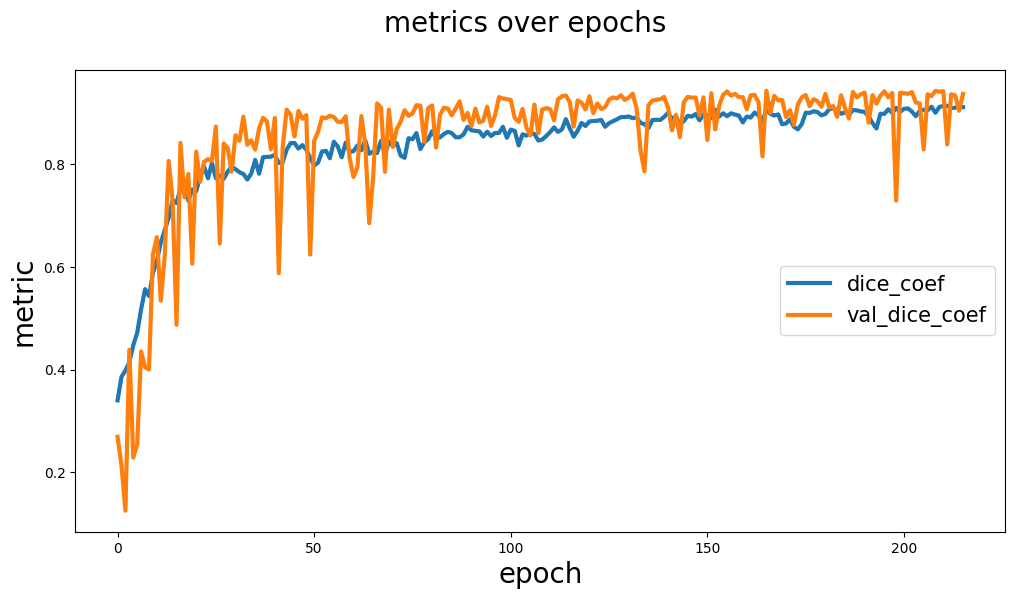

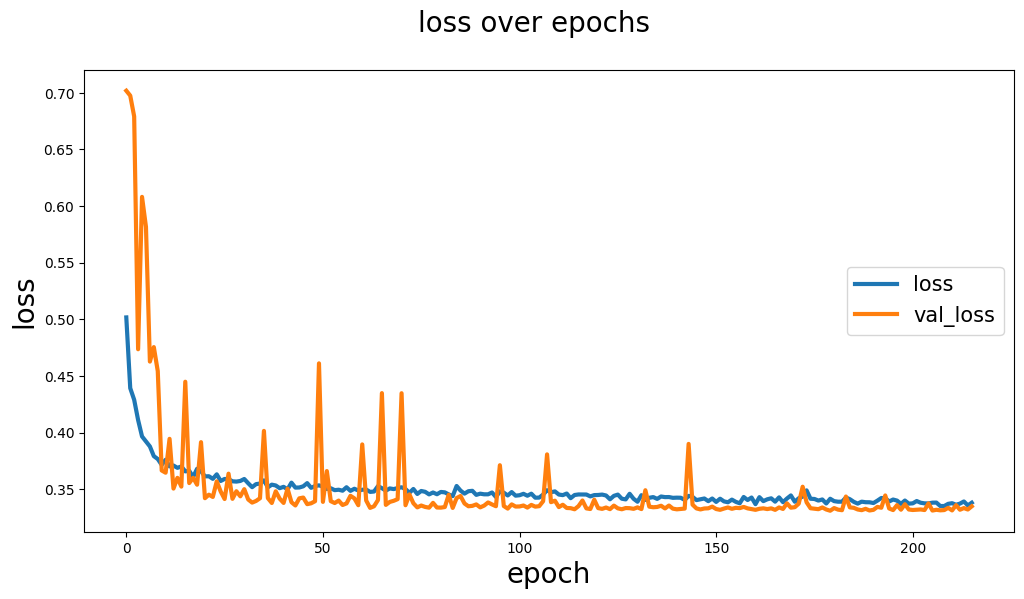

 -> model_study :  trained_Unet_size600_f32_b16_l4_do0.1_Std_BN
 -> model_filename :  trained_model/CS/trained_Unet_size600_f32_b16_l4_do0.1_Std_BN_input_epoch_{epoch:02d}.h5
Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 0.5015 - dice_coef: 0.3346
Epoch 1: val_dice_coef improved from -inf to 0.27261, saving model to trained_model/CS\trained_Unet_size600_f32_b16_l4_do0.1_Std_BN_input_epoch_01.h5
50/50 [==============================] - 17s 297ms/step - loss: 0.5015 - dice_coef: 0.3346 - val_loss: 0.7043 - val_dice_coef: 0.2726
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.4289 - dice_coef: 0.3917
Epoch 2: val_dice_coef did not improve from 0.27261
50/50 [==============================] - 16s 325ms/step - loss: 0.4289 - dice_coef: 0.3917 - val_loss: 0.6211 - val_dice_coef: 0.2494
Epoch 3/500
50/50 [==============================] - ETA: 0s - loss: 0.4070 - dice_coef: 0.4087
Epoch 3: val_dice_coef did not improve from 0.27261
50/50 [========

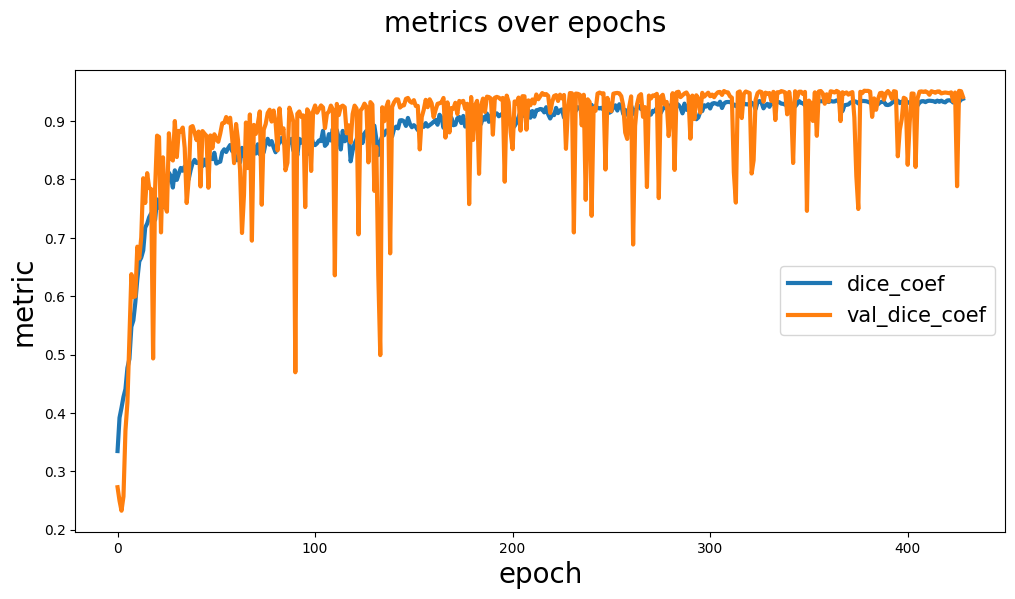

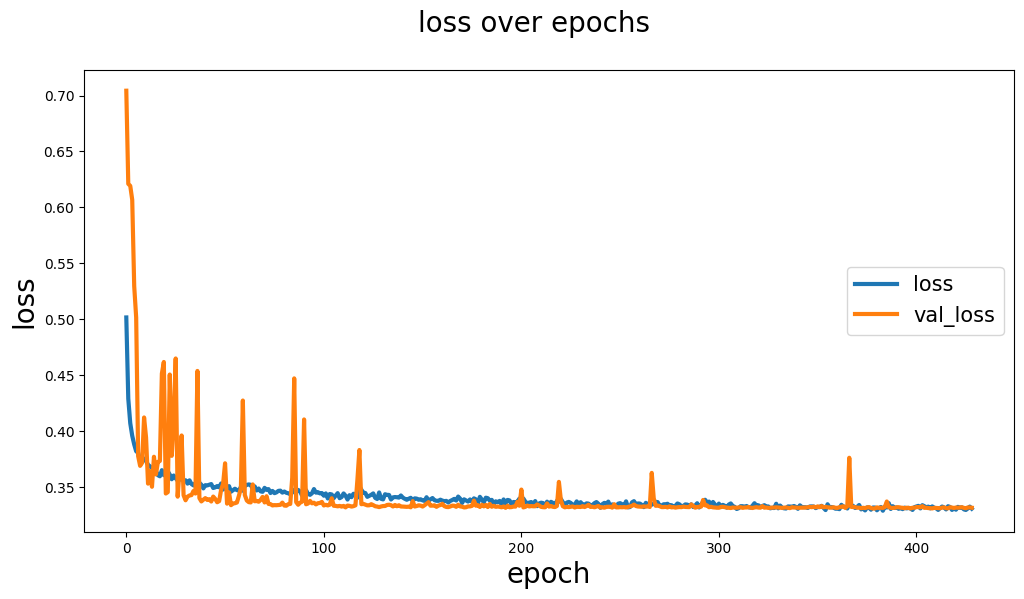

 -> model_study :  trained_Unet_size500_f32_b16_l4_do0.1_Std_BN
 -> model_filename :  trained_model/CS/trained_Unet_size500_f32_b16_l4_do0.1_Std_BN_input_epoch_{epoch:02d}.h5
Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 0.4897 - dice_coef: 0.3446
Epoch 1: val_dice_coef improved from -inf to 0.27900, saving model to trained_model/CS\trained_Unet_size500_f32_b16_l4_do0.1_Std_BN_input_epoch_01.h5
50/50 [==============================] - 17s 298ms/step - loss: 0.4897 - dice_coef: 0.3446 - val_loss: 0.7018 - val_dice_coef: 0.2790
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.4115 - dice_coef: 0.4027
Epoch 2: val_dice_coef did not improve from 0.27900
50/50 [==============================] - 16s 321ms/step - loss: 0.4115 - dice_coef: 0.4027 - val_loss: 0.6979 - val_dice_coef: 0.0714
Epoch 3/500
50/50 [==============================] - ETA: 0s - loss: 0.3980 - dice_coef: 0.4204
Epoch 3: val_dice_coef did not improve from 0.27900
50/50 [========

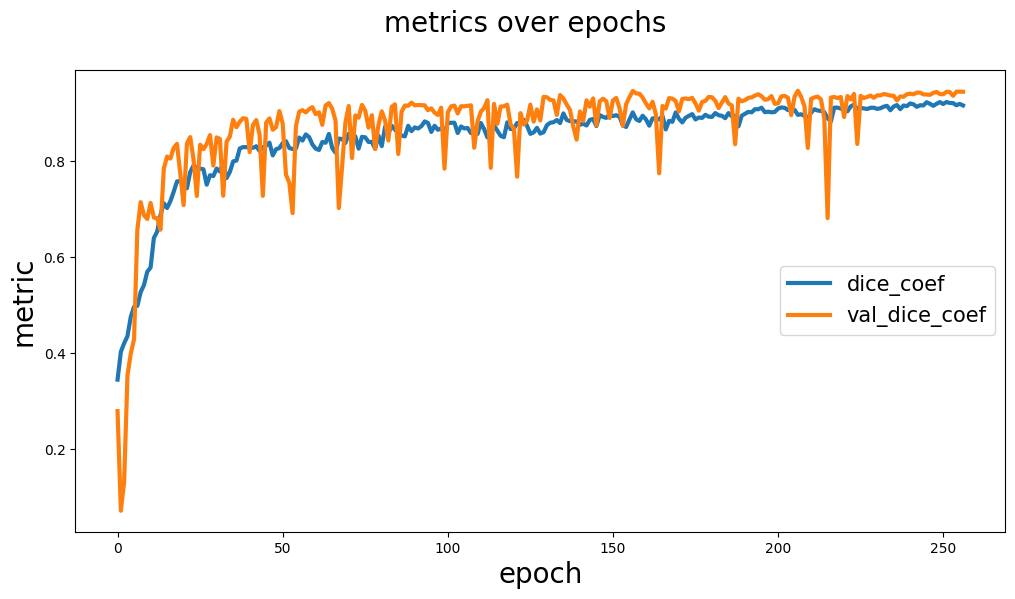

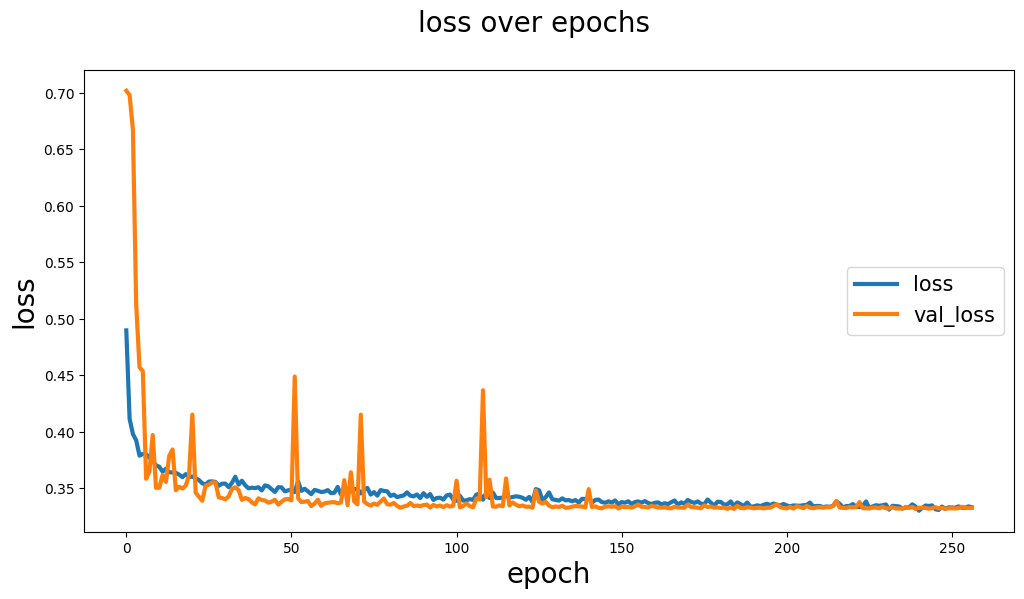

 -> model_study :  trained_Unet_size400_f32_b16_l4_do0.1_Std_BN
 -> model_filename :  trained_model/CS/trained_Unet_size400_f32_b16_l4_do0.1_Std_BN_input_epoch_{epoch:02d}.h5
Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 0.4834 - dice_coef: 0.3511
Epoch 1: val_dice_coef improved from -inf to 0.27900, saving model to trained_model/CS\trained_Unet_size400_f32_b16_l4_do0.1_Std_BN_input_epoch_01.h5
50/50 [==============================] - 17s 296ms/step - loss: 0.4834 - dice_coef: 0.3511 - val_loss: 0.7018 - val_dice_coef: 0.2790
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.4132 - dice_coef: 0.3997
Epoch 2: val_dice_coef did not improve from 0.27900
50/50 [==============================] - 14s 282ms/step - loss: 0.4132 - dice_coef: 0.3997 - val_loss: 0.6056 - val_dice_coef: 0.2409
Epoch 3/500
50/50 [==============================] - ETA: 0s - loss: 0.4033 - dice_coef: 0.4106
Epoch 3: val_dice_coef did not improve from 0.27900
50/50 [========

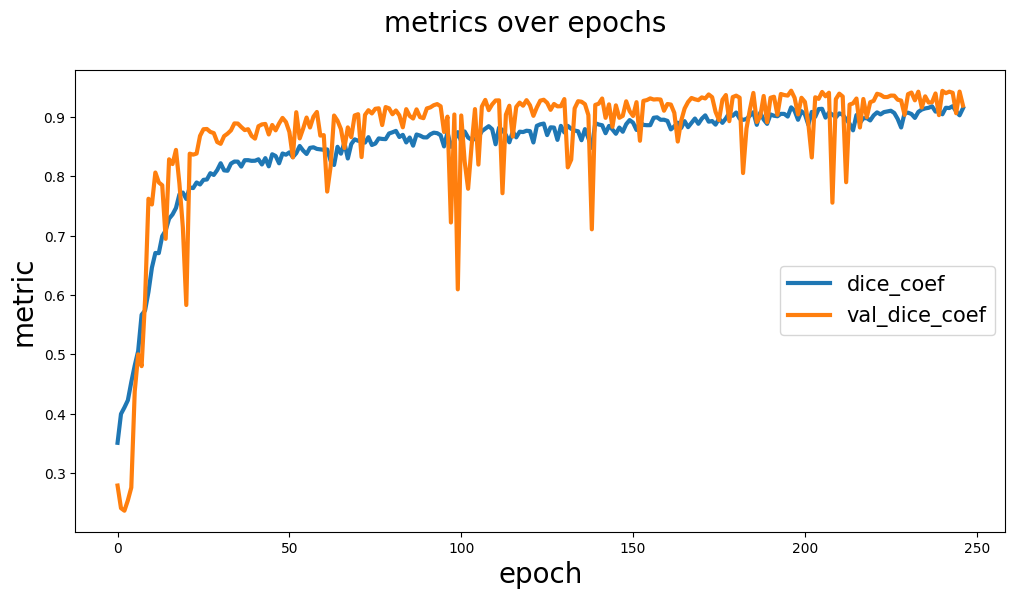

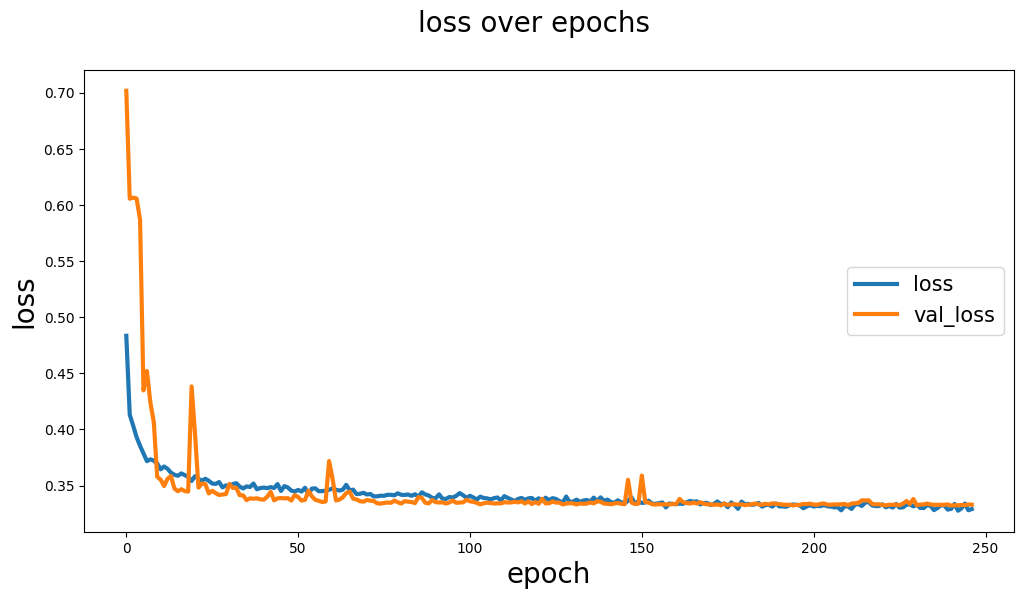

 -> model_study :  trained_Unet_size300_f32_b16_l4_do0.1_Std_BN
 -> model_filename :  trained_model/CS/trained_Unet_size300_f32_b16_l4_do0.1_Std_BN_input_epoch_{epoch:02d}.h5
Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 0.4798 - dice_coef: 0.3540
Epoch 1: val_dice_coef improved from -inf to 0.15919, saving model to trained_model/CS\trained_Unet_size300_f32_b16_l4_do0.1_Std_BN_input_epoch_01.h5
50/50 [==============================] - 17s 298ms/step - loss: 0.4798 - dice_coef: 0.3540 - val_loss: 0.7027 - val_dice_coef: 0.1592
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.4220 - dice_coef: 0.3965
Epoch 2: val_dice_coef improved from 0.15919 to 0.19659, saving model to trained_model/CS\trained_Unet_size300_f32_b16_l4_do0.1_Std_BN_input_epoch_02.h5
50/50 [==============================] - 14s 288ms/step - loss: 0.4220 - dice_coef: 0.3965 - val_loss: 0.6262 - val_dice_coef: 0.1966
Epoch 3/500
50/50 [==============================] - ETA: 0s -

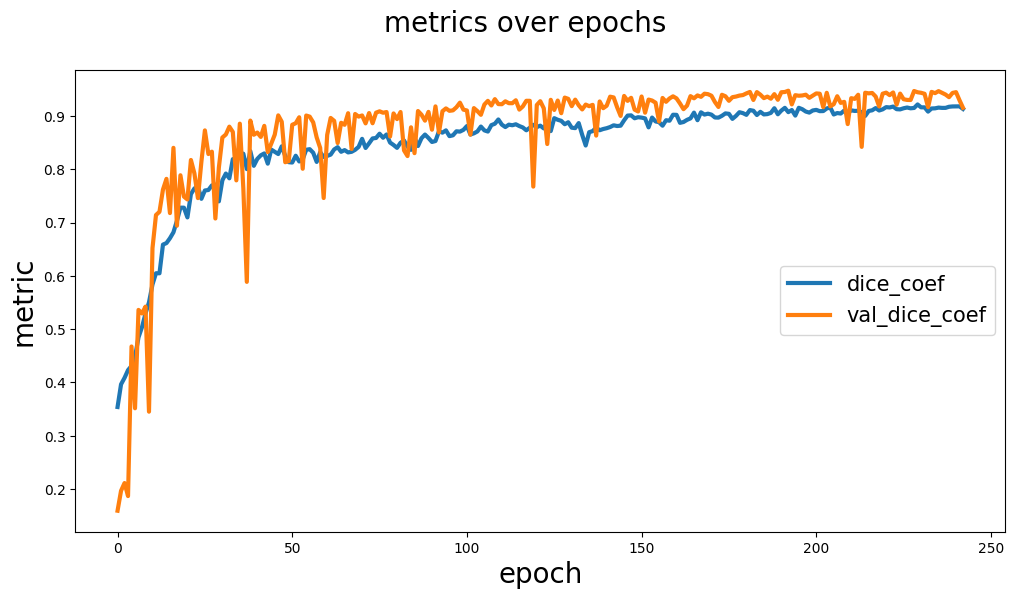

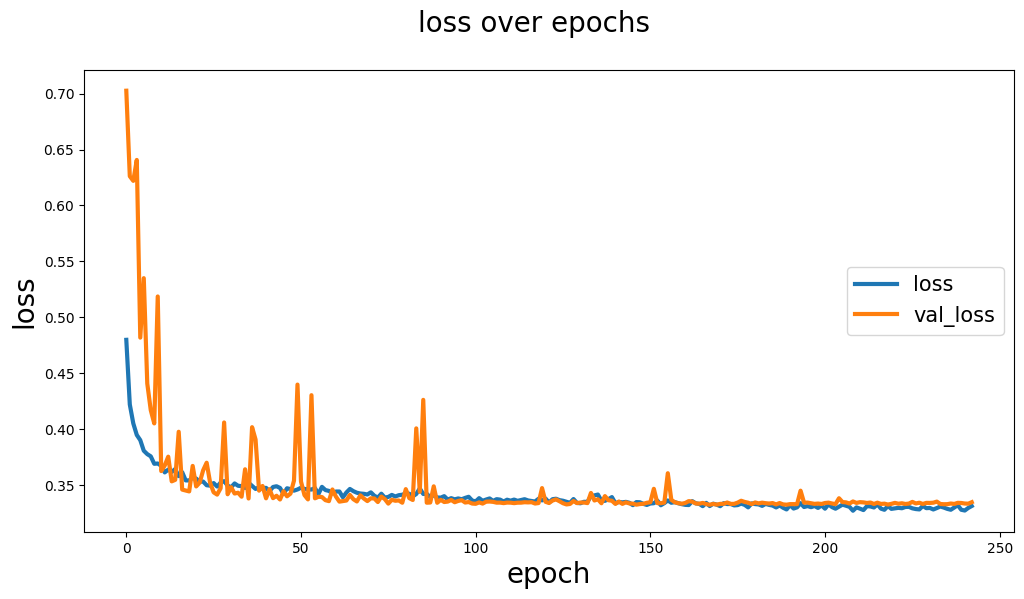

 -> model_study :  trained_Unet_size200_f32_b16_l4_do0.1_Std_BN
 -> model_filename :  trained_model/CS/trained_Unet_size200_f32_b16_l4_do0.1_Std_BN_input_epoch_{epoch:02d}.h5
Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 0.4978 - dice_coef: 0.3343
Epoch 1: val_dice_coef improved from -inf to 0.43669, saving model to trained_model/CS\trained_Unet_size200_f32_b16_l4_do0.1_Std_BN_input_epoch_01.h5
50/50 [==============================] - 17s 298ms/step - loss: 0.4978 - dice_coef: 0.3343 - val_loss: 0.6286 - val_dice_coef: 0.4367
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.4252 - dice_coef: 0.3920
Epoch 2: val_dice_coef improved from 0.43669 to 0.64915, saving model to trained_model/CS\trained_Unet_size200_f32_b16_l4_do0.1_Std_BN_input_epoch_02.h5
50/50 [==============================] - 14s 286ms/step - loss: 0.4252 - dice_coef: 0.3920 - val_loss: 0.5506 - val_dice_coef: 0.6491
Epoch 3/500
50/50 [==============================] - ETA: 0s -

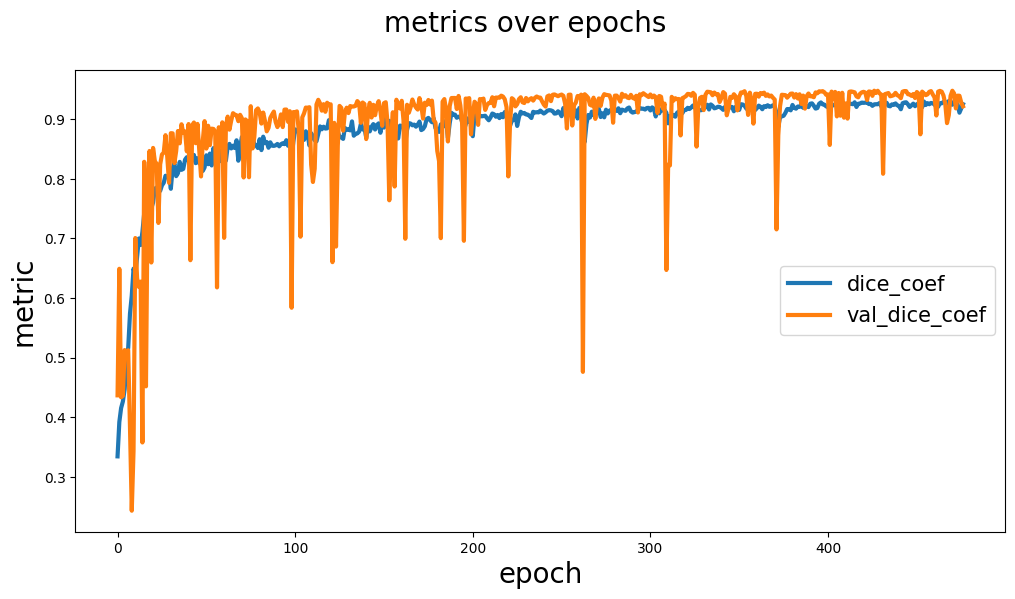

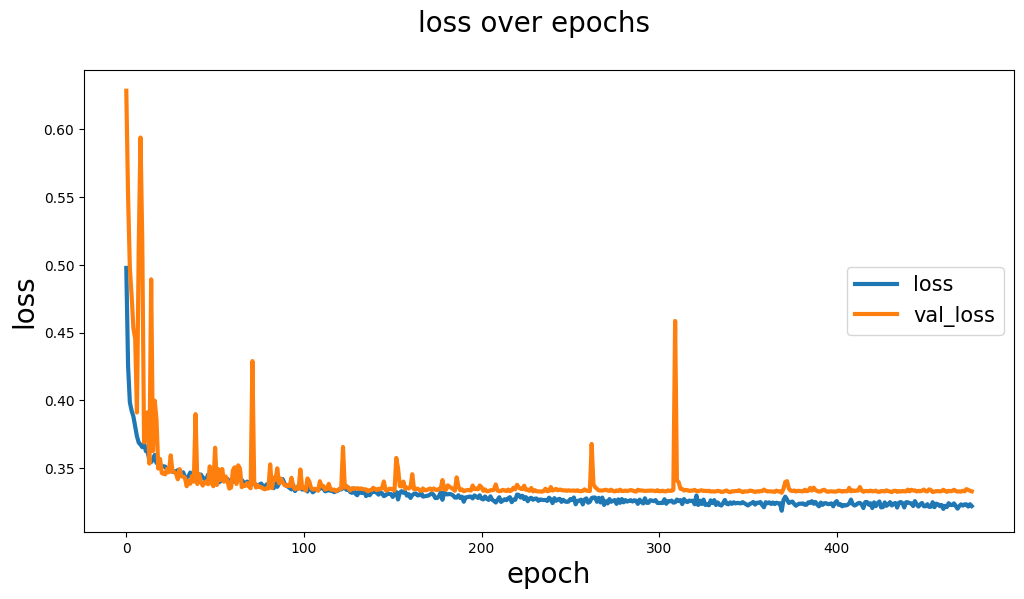

 -> model_study :  trained_Unet_size100_f32_b16_l4_do0.1_Std_BN
 -> model_filename :  trained_model/CS/trained_Unet_size100_f32_b16_l4_do0.1_Std_BN_input_epoch_{epoch:02d}.h5
Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 0.4706 - dice_coef: 0.3525
Epoch 1: val_dice_coef improved from -inf to 0.12641, saving model to trained_model/CS\trained_Unet_size100_f32_b16_l4_do0.1_Std_BN_input_epoch_01.h5
50/50 [==============================] - 17s 285ms/step - loss: 0.4706 - dice_coef: 0.3525 - val_loss: 0.6933 - val_dice_coef: 0.1264
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.3912 - dice_coef: 0.4117
Epoch 2: val_dice_coef improved from 0.12641 to 0.18059, saving model to trained_model/CS\trained_Unet_size100_f32_b16_l4_do0.1_Std_BN_input_epoch_02.h5
50/50 [==============================] - 14s 273ms/step - loss: 0.3912 - dice_coef: 0.4117 - val_loss: 0.6786 - val_dice_coef: 0.1806
Epoch 3/500
50/50 [==============================] - ETA: 0s -

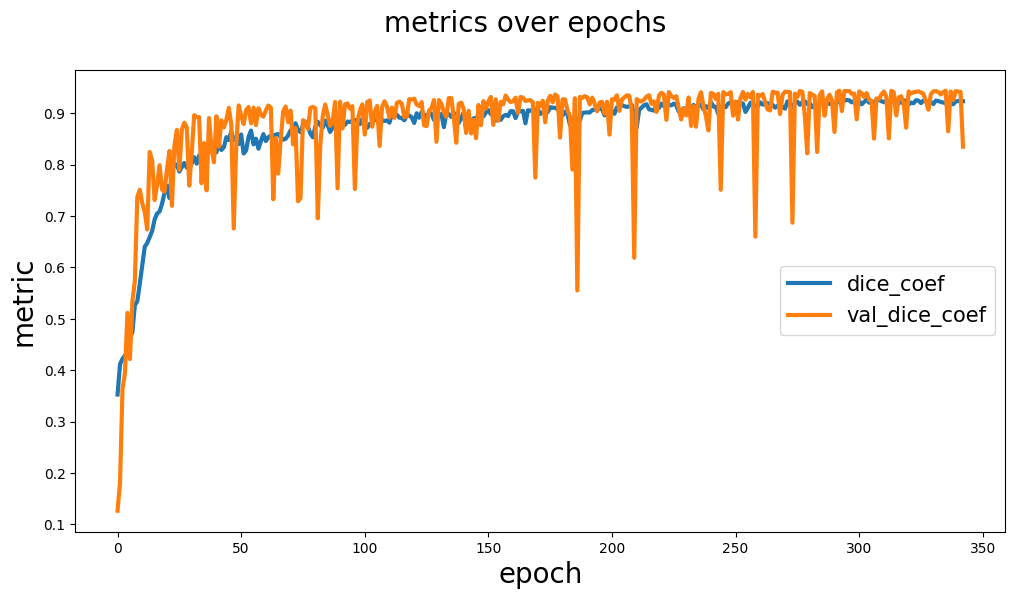

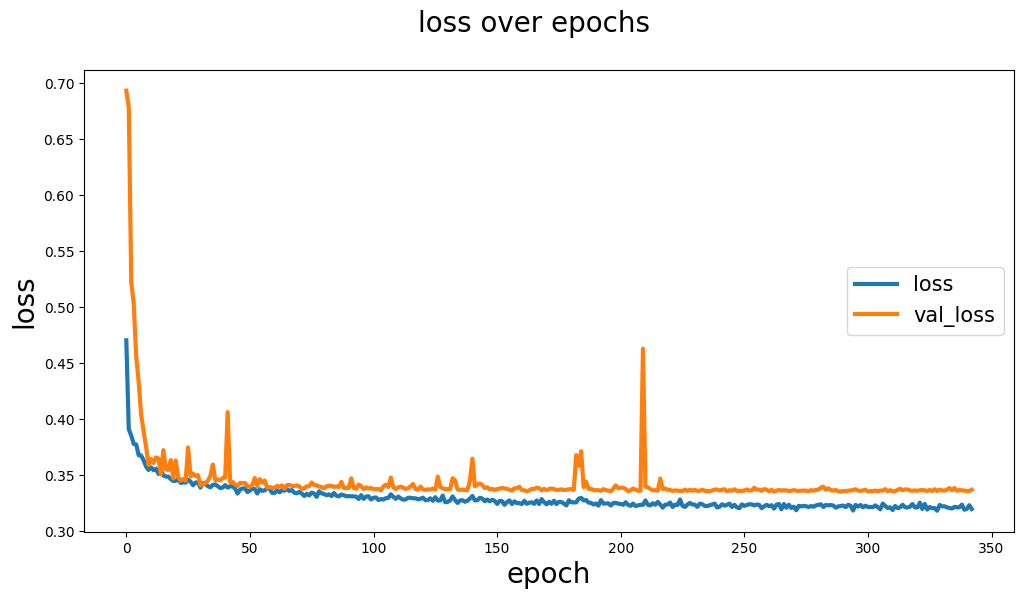

 -> model_study :  trained_Unet_size1_f32_b16_l4_do0.1_Std_BN
 -> model_filename :  trained_model/CS/trained_Unet_size1_f32_b16_l4_do0.1_Std_BN_input_epoch_{epoch:02d}.h5
Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 0.4420 - dice_coef: 0.3795
Epoch 1: val_dice_coef improved from -inf to 0.27393, saving model to trained_model/CS\trained_Unet_size1_f32_b16_l4_do0.1_Std_BN_input_epoch_01.h5
50/50 [==============================] - 16s 285ms/step - loss: 0.4420 - dice_coef: 0.3795 - val_loss: 0.7019 - val_dice_coef: 0.2739
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 0.3790 - dice_coef: 0.4219
Epoch 2: val_dice_coef did not improve from 0.27393
50/50 [==============================] - 14s 269ms/step - loss: 0.3790 - dice_coef: 0.4219 - val_loss: 0.6425 - val_dice_coef: 0.1920
Epoch 3/500
50/50 [==============================] - ETA: 0s - loss: 0.3669 - dice_coef: 0.4373
Epoch 3: val_dice_coef improved from 0.27393 to 0.39183, saving model to 

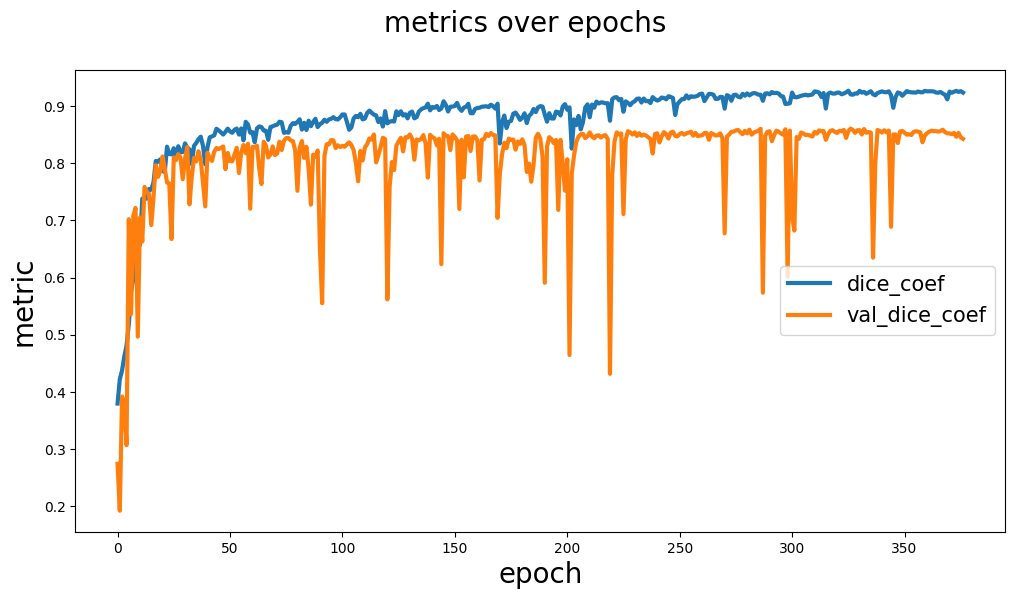

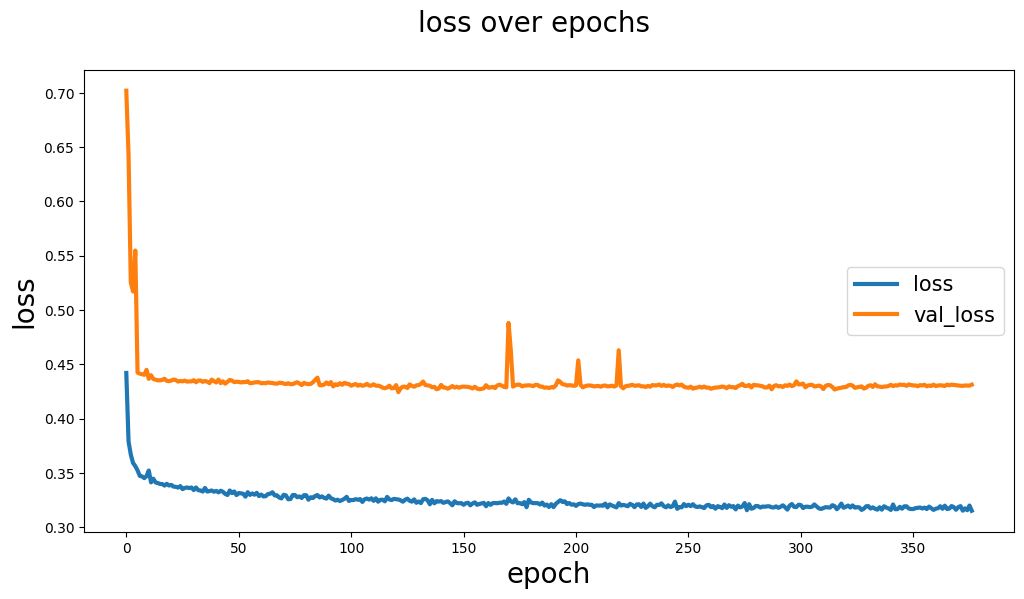

In [27]:


def train_model(train_gen, X_valid, y_valid, input_shape, size, model_path='trained_model/CS/'):
    # 定义模型
    if 'model' in locals(): 
        del model

    model = custom_unet(
        input_shape,
        use_batch_norm=BATCHNORM_ON,
        num_classes=y_train[0].shape[-1],
        filters=NBFILTERS_L1_UNET, 
        dropout=DROPOUT_RATE,
        num_layers=NBLAYERS_UNET,
        output_activation='softmax',
        kernel_regularizer=None
    )

    # 创建模型名称，包含训练集大小
    model_name = f'trained_Unet_size{size}_f{NBFILTERS_L1_UNET}_b{BATCH_SIZE}_l{NBLAYERS_UNET}_do{DROPOUT_RATE}_Std'
    if BATCHNORM_ON:
        model_name += '_BN'
    model_filename = os.path.join(model_path, f'{model_name}_input_epoch_{{epoch:02d}}.h5')
    print(" -> model_study : ", model_name)
    print(" -> model_filename : ", model_filename)

    # 创建回调函数
    callback_checkpoint = ModelCheckpoint(model_filename, verbose=1, monitor='val_dice_coef', mode='max', save_best_only=True)
    callback_earlystopping = EarlyStopping(monitor='val_dice_coef', mode='max', patience=NBPATIENCE_EPOCHS, restore_best_weights=True)
    current_datetime = datetime.datetime.now()
    log_folder_name = os.path.join("logs", f"{current_datetime.strftime('%Y%m%d_%H%M%S-')}{model_name}")
    os.makedirs(log_folder_name, exist_ok=True)
    tensorboard_callback = TensorBoard(log_dir=log_folder_name)

    # 编译模型
    model.compile(loss=dice_loss, optimizer=Adam(learning_rate=0.005), metrics=[dice_coef])

    # 训练模型
    history = model.fit(
        train_gen,
        steps_per_epoch=NBSTEPS_PER_EPOCH,
        batch_size=BATCH_SIZE,
        epochs=NBEPOCHS,
        validation_data=(X_valid, y_valid),
        shuffle=True,
        verbose=1,
        callbacks=[callback_earlystopping, callback_checkpoint, tensorboard_callback]
    )

    # 绘制训练历史
    plot_segm_history(history, metrics=['dice_coef', 'val_dice_coef'])

# 对于每个训练集大小，调用 train_model 函数
for size in sizes:
    train_gen = train_generators[f"train_gen{size}"]
    train_model(train_gen, X_valid, y_valid, input_shape=(IMG_SIZE, IMG_SIZE, 1), size=size)
